In [2]:
!ls

classifiers_mhcld.ipynb
codebook_descriptions.pickle
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_mental_health_client-level_data.ipynb
to_do.txt


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
NUM_POINTS = 10_000
data = pd.read_csv("mhcld_puf_2021.csv")
data = data[:NUM_POINTS]

In [5]:
# Load data the codebook descriptions
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)
assert set(list(data.columns)) == set(list(codebook_descriptions.keys()))

In [6]:
#columns to drop. reasoning in t-sne notebook.
drop_cols = ['YEAR','CASEID','SUB','MH1','MH2','MH3','SMISED','DETNLF','NUMMHS','STATEFIP','REGION','DIVISION']
data = data.drop(columns = drop_cols)

In [7]:
#disorder columns. 0/1 binary. these are dignoses for the disorders
disorder_cols = ['TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [8]:
#columns which require a transformation to standardize to 0-1. reasoning in t-sne notebook.
transform_cols = ['AGE','EDUC','GENDER','SPHSERVICE','CMPSERVICE','OPISERVICE','RTCSERVICE','IJSSERVICE','SAP','VETERAN ']
max_age = max(data['AGE'])
max_educ = max(data['EDUC'])
data['AGE'] = data['AGE'].apply(lambda x: x/max_age)
data['EDUC'] = data['EDUC'].apply(lambda x: 0 if x==-9 else x/max_educ)
data['GENDER'] = data['GENDER'].apply(lambda x: .5 if x==-9 else x-1)
data['SAP'] = data['SAP'].apply(lambda x: .5 if x==-9 else x-1)
data['VETERAN'] = data['VETERAN'].apply(lambda x: .5 if x==-9 else x-1)
data['SPHSERVICE'] = data['SPHSERVICE'].apply(lambda x: x-1)
data['CMPSERVICE'] = data['CMPSERVICE'].apply(lambda x: x-1)
data['OPISERVICE'] = data['OPISERVICE'].apply(lambda x: x-1)
data['RTCSERVICE'] = data['RTCSERVICE'].apply(lambda x: x-1)
data['IJSSERVICE'] = data['IJSSERVICE'].apply(lambda x: x-1)

In [9]:
#categorical columns w/ more than two categorices
#encode them with one-hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']
one_hot_enc=OneHotEncoder().fit(data[one_hot_cols])
one_hot_categorical_data = one_hot_enc.transform(data[one_hot_cols]).toarray()
one_hot_feature_names=list(one_hot_enc.get_feature_names_out(['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']))
one_hot_encoded_df = pd.DataFrame(data=one_hot_categorical_data,columns=one_hot_feature_names)
print(sum(len(item) for item in one_hot_enc.categories_))
data = data.drop(columns=one_hot_cols)
data = data.join(one_hot_encoded_df)
print(data.shape)

26
(10000, 49)


In [10]:
#create labels for the 13 disorder features
#binary encode them since they are 0/1
#take the total number of disorders present
#create unique leabel for each disorder, plus one for no disorder and one for multiple disorders
#use k-means to automatically label the clusters
from sklearn.cluster import KMeans
def get_labels(dataset, label_type='binary_encode',num_clusters=5):
    labels = []
    for row in dataset[disorder_cols][:NUM_POINTS].itertuples():
        if label_type=='binary_encode':
            #binary number encoding of disorders
            encoding = sum(row[i]*2**(i-1) for i in range(1,len(row)))
            print([row[i] for i in range(1,len(row))],encoding)
            labels.append(encoding)
        #sum the total number of disorders
        num_disorders = sum(row[i] for i in range(1,len(row)))
        if label_type == 'num_disorders':
            labels.append(num_disorders)
        #unique labels for pure disorders, separate categories for multiple or no disorders
        if label_type == 'unique_disorders':
            if num_disorders == 0:
                labels.append('no_disorder')
            if num_disorders == 1:
                #get the index (string) of the column with value 1
                labels.append(disorder_cols[list(row)[1:].index(1)])
            if num_disorders > 1:
                labels.append('multi-disorder')
        #generate labels using k-means
        if label_type == 'k-means':
            kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, random_state=0, n_init=10)
            kmeans.fit(dataset)
            labels = kmeans.labels_
    label_df = pd.DataFrame(labels,columns=['label'])
    return label_df

In [ ]:
kmeans_label_df = get_labels(data,label_type='k-means')

In [57]:
#data_labeled = label_df.merge(data, left_index=True, right_index=True)

In [ ]:
#tsne_results_kmeans_label = kmeans_label_df.merge(data, left_index=True, right_index=True)

In [64]:
#PERFORM RANDOM FOREST CLASSIFICATION
#may have unbalanced classes, too many in multi-disorder

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [66]:
X = data.drop(columns=disorder_cols)
y = np.squeeze(label_df)

In [67]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [68]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [69]:
y_pred_rf = rf.predict(X_test)

In [70]:
#zero_division warning - unbalanced classes, i.e. multi-disorder has too many elements
#17% accuracy on multi-disorder-labeled data
#36% accuracy on unique-disorder-labeled data 
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_rf, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, y_pred_rf, average='weighted')
print("Recall:", recall)

Accuracy: 0.32
Precision: 0.28961853071062776
Recall: 0.32


/Users/jacksonwalters/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
vis_arr = multilabel_confusion_matrix(y_test, y_pred_rf)

In [72]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CFS_MATRIX for " + class_label)

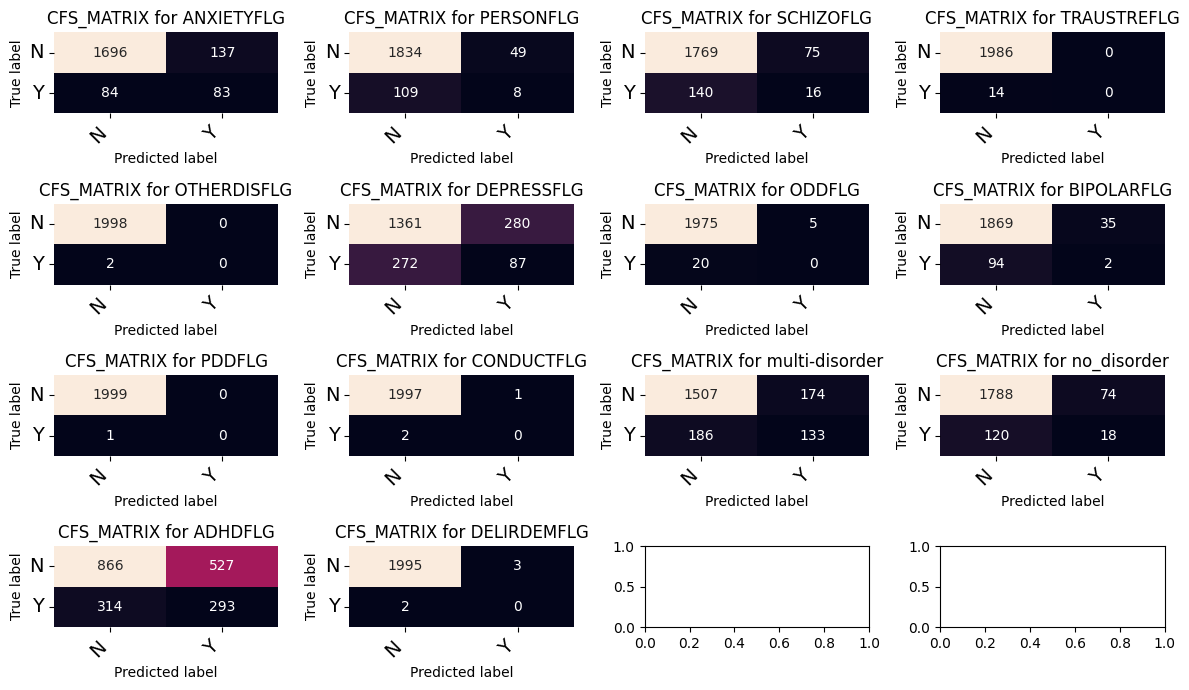

In [73]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, list(set(labels))):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
fig.savefig("./plots/confusion_matrix_mhcld_unique-disorder-label.png")
plt.show()

In [110]:
#MULTI-CLASS LOGISTIC REGRESSION

In [83]:
X = data.drop(columns=disorder_cols)
y = np.squeeze(label_df)

In [92]:
#perform stratified k-fold testing
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
scores = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    #fit the logistic regression model
    clf = LogisticRegression(solver='lbfgs', max_iter=3000).fit(X.iloc[train_index], y.iloc[train_index])
    #get predictions for logistic regression
    y_pred_logistic = clf.predict(X.iloc[test_index])
    #get accuracy, precision, recall scores for the predicted values vs. the test values in the k-fold
    accuracy = accuracy_score(y.iloc[test_index], y_pred_logistic)
    precision = precision_score(y.iloc[test_index], y_pred_logistic, average='weighted')
    recall = recall_score(y.iloc[test_index], y_pred_logistic, average='weighted')
    scores.append([accuracy,precision,recall])

/Users/jacksonwalters/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonwalters/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
print(scores)

[[0.3634, 0.28525707437668113, 0.3634], [0.3664, 0.3711362589368151, 0.3664]]


In [33]:
#MULTI-CLASS LOGISTIC REGRESSION w/ K-MEAN LABELS

In [48]:
X = data.drop(columns=disorder_cols)
y = np.squeeze(kmeans_label_df)

In [49]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
clf = LogisticRegression(solver='lbfgs', max_iter=3000).fit(X_train, y_train)

In [51]:
y_pred_logistic_kmeans = clf.predict(X_test)

In [52]:
accuracy = accuracy_score(y_test, y_pred_logistic_kmeans)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_logistic_kmeans, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, y_pred_logistic_kmeans, average='weighted')
print("Recall:", recall)

Accuracy: 0.926
Precision: 0.9222371300764367
Recall: 0.926


In [58]:
#OUTPUT PROBABILITY VECTOR = [0-1, 0-1, ..., 0-1]
#get probabilities when the labels are one of the 13 labels from k-means
probabilities_logistic_kmeans = clf.predict_proba(X_test)

In [59]:
probabilities_logistic_kmeans[0]

array([6.12316335e-08, 1.35082713e-05, 4.23752131e-07, 2.05599571e-04,
       2.56083244e-05, 1.97009964e-03, 2.33639437e-01, 4.62734210e-02,
       2.34926277e-09, 2.86515194e-06, 7.17837552e-01, 2.74158516e-05,
       4.00619205e-06])